In [ ]:
Quantas retiradas de barra é bom
melhor seção

In [1]:
import sys
sys.path.insert(0, '../')
import fconcrete as fc
import matplotlib.pyplot as plt
from pytest import approx
import numpy as np
np.set_printoptions(precision=4, suppress=True, linewidth=3000)
from math import sin, tan,  pi
from fconcrete.helpers import cond
import copy

In [2]:
plt.rcParams["figure.figsize"] = (25,10)

In [3]:
material = fc.Concrete('20 MPa', 1)
section = fc.Rectangle(25,60)

f1 = fc.Load.UniformDistributedLoad(-0.1622, x_begin=0, x_end=113)
f2 = fc.Load.UniformDistributedLoad(-0.4994, x_begin=113, x_end=583)
f3 = fc.Load.UniformDistributedLoad(-0.4196, x_begin=583, x_end=1188)

n1 = fc.Node.SimpleSupport(x=0, length=20)
n2 = fc.Node.SimpleSupport(x=113, length=20)
n3 = fc.Node.SimpleSupport(x=583, length=20)
n4 = fc.Node.SimpleSupport(x=1188, length=20)

bar1 = fc.BeamElement([n1, n2], section, material)
bar2 = fc.BeamElement([n2, n3], section, material)
bar3 = fc.BeamElement([n3, n4], section, material)

    
beam = fc.ConcreteBeam(
    loads = [f1, f2, f3],
    beam_elements = [bar1, bar2, bar3],
    bar_steel_max_removal = 3,
    transversal_bar_inclination_angle=90,
    available_long_steel_bars = fc.AvailableLongConcreteSteelBar(diameters=[8]),
    available_transv_steel_bars = fc.AvailableTransvConcreteSteelBar(diameters=[8])
)

In [4]:
self = beam

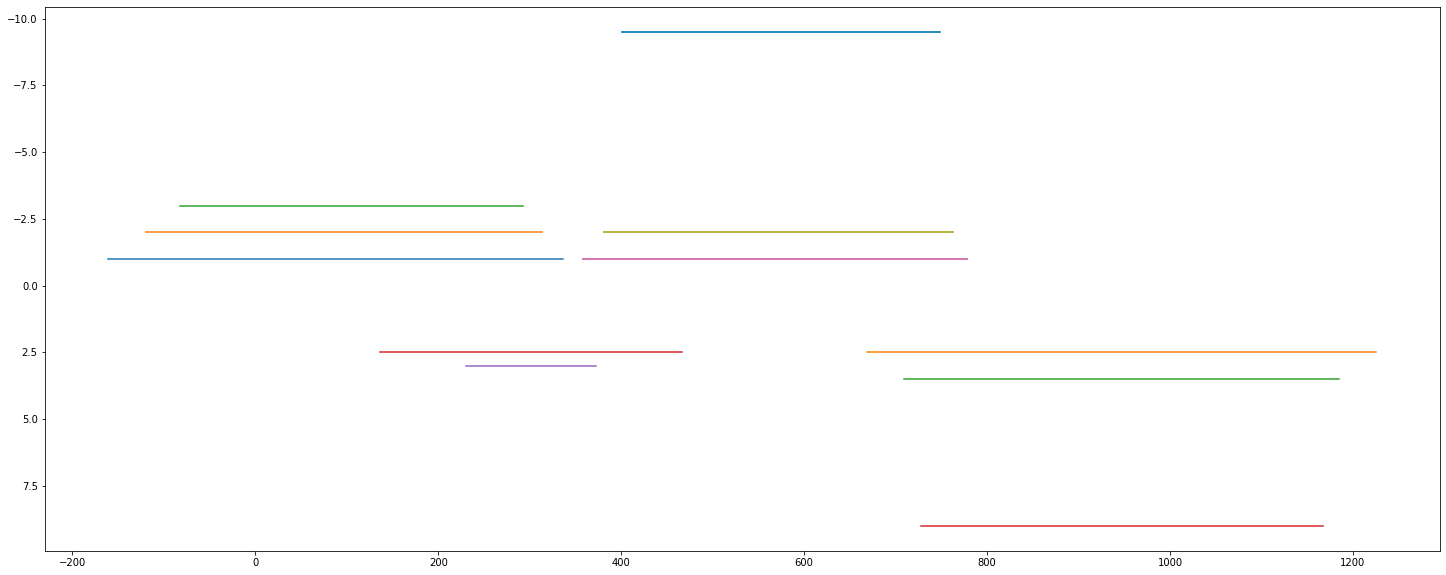

In [5]:
self.long_steel_bars.plot()

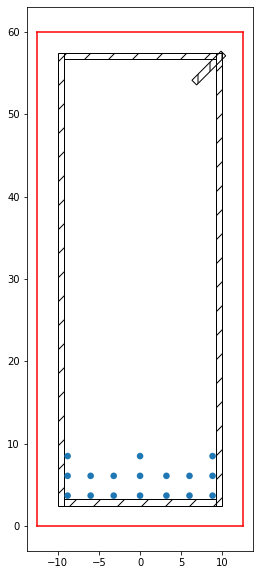

In [6]:
self.plotTransversalInX(1000)